# Model Design, Evaluation and Selection workflow ( e.g. Classification )

## Contents :
1. Importing libraries                                                    
2. Generating dataset                                                               
3. Create train and test set                                              
4. Selected Classifiers                                                            
5. Hyper-parameters                                                       
6. Feature Selection: Removing highly correlated features                 
7. Tuning a classifier to use with RFECV                                  
8. Custom pipeline object to use with RFECV                               
9. Feature Selection: Recursive Feature Selection with Cross Validation   
10. Performance Curve                                                     
11. Feature Selection: Recursive Feature Selection                        
12. Visualizing Selected Features Importance                              
13. Classifier Tuning and Evaluation                                      
14. Visualing Results                                                     

In [6]:
# uncomment the following statement if seaborn not already installed
# !pip install seaborn
# !conda install seaborn

In [7]:
# 1. Importing libraries For reading, visualizing, and preprocessing data

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
# Install Imputer from sklearn
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

## Generating Dataset

Generation of a Madelon-like synthetic data set using Scikit-learn for a classification task. The Madelon data set is an artificial data set that contains 32 clusters placed on the vertices of a five-dimensional hyper-cube with sides of length 1. The clusters are randomly labeled 1 or -1 (2 classes).

For the sake of demonstration of different feature conditions:

- It will contain 30 features
- Column 1-5 : Informative features
- Column 6-20 : Redundant features
- Column 21-25 : Repeated features
- Column 26-30 : Useless features

In [8]:
# 2. Generating dataset

X, y = make_classification(n_samples = 1000, n_features = 30, n_informative = 5,
                           n_redundant = 15, n_repeated = 5, 
                           n_clusters_per_class = 2, class_sep = 0.5,
                           random_state = 1000, shuffle = False)

# Numpy array to pandas dataframe
labels = [f"Feature {ii+1}" for ii in range(X.shape[1])]
X = pd.DataFrame(X, columns = labels)
y = pd.DataFrame(y, columns = ["Target"])

In [9]:
# 3. Create train and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,
                                                    random_state = 1000)

## Classifiers

We will train and tune 18 classifiers and evaluate their performance using AUC (Area Under The Curve) ROC (Receiver Operating Characteristics). ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model is at distinguishing between patients with disease and no disease.


Each classifier is given a label denoted by the string contained between parentheses.

1. Linear Discrimination Analysis (LDA)
2. Quadratic Discriminant Analysis (QDA)
3. Adaboost Classifier (AdaBoost)
4. Bagging Classifier (Bagging)
5. Extra Trees Classifier (Extra Trees Ensemble)
6. Gradient Boosting Classifier (Gradient Boosting)
7. Random Forest Classifier (Random Forest)
8. Ridge Classifier (Ridge)
9. SGD Classifier (SGD)
10. Bernoulli NB Classifier (BNB)
11. Gaussian NB Classifier (GNB)
12. K Nearest Neighbors Classifier (KNN)
13. MLP Classifier (MLP)
14. Linear SVC (LSVC)
15. Nu SVC (NuSVC)
16. SVC (SVC)
17. Decision Tree Classifier (DTC)
18. Extra Tree Classifier (ETC)

In [10]:
# Create list of tuples with classifier label and classifier object

classifiers = {}
classifiers.update({"LDA": LinearDiscriminantAnalysis()})
classifiers.update({"QDA": QuadraticDiscriminantAnalysis()})
classifiers.update({"AdaBoost": AdaBoostClassifier()})
classifiers.update({"Bagging": BaggingClassifier()})
classifiers.update({"Extra Trees Ensemble": ExtraTreesClassifier()})
classifiers.update({"Gradient Boosting": GradientBoostingClassifier()})
classifiers.update({"Random Forest": RandomForestClassifier()})
classifiers.update({"Ridge": RidgeClassifier()})
classifiers.update({"SGD": SGDClassifier()})
classifiers.update({"BNB": BernoulliNB()})
classifiers.update({"GNB": GaussianNB()})
classifiers.update({"KNN": KNeighborsClassifier()})
classifiers.update({"MLP": MLPClassifier()})
classifiers.update({"LSVC": LinearSVC()})
classifiers.update({"NuSVC": NuSVC()})
classifiers.update({"SVC": SVC()})
classifiers.update({"DTC": DecisionTreeClassifier()})
classifiers.update({"ETC": ExtraTreeClassifier()})

# Create dict of decision function labels
DECISION_FUNCTIONS = {"Ridge", "SGD", "LSVC", "NuSVC", "SVC"}

# Create dict for classifiers with feature_importances_ attribute
FEATURE_IMPORTANCE = {"Gradient Boosting", "Extra Trees Ensemble", "Random Forest"}

## Hyperparameters

Here, Dictionary is created whose key value pair consists of

- **Key :** String denoting the classifier
- **Value :** Dictionary of Hyper-parameter of respective classifier.

By no means do the hyper-parameters specified here represent the optimal hyper-parameter grid for each classifier.The hyperparameter grid can be experimented around for understanding.

In [11]:
# Defining the hyper-parameter grid for each classifier

# Initiate parameter grid
parameters = {}

# Update dict with LDA
parameters.update({"LDA": {"classifier__solver": ["svd"], 
                                         }})

# Update dict with QDA
parameters.update({"QDA": {"classifier__reg_param":[0.01*ii for ii in range(0, 101)], 
                                         }})
# Update dict with AdaBoost
parameters.update({"AdaBoost": { 
                                "classifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],
                                "classifier__n_estimators": [200],
                                "classifier__learning_rate": [0.001, 0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 1.0]
                                 }})

# Update dict with Bagging
parameters.update({"Bagging": { 
                                "classifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],
                                "classifier__n_estimators": [200],
                                "classifier__max_features": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                "classifier__n_jobs": [-1]
                                }})

# Update dict with Gradient Boosting
parameters.update({"Gradient Boosting": { 
                                        "classifier__learning_rate":[0.15,0.1,0.05,0.01,0.005,0.001], 
                                        "classifier__n_estimators": [200],
                                        "classifier__max_depth": [2,3,4,5,6],
                                        "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                        "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                        "classifier__max_features": ["auto", "sqrt", "log2"],
                                        "classifier__subsample": [0.8, 0.9, 1]
                                         }})


# Update dict with Extra Trees
parameters.update({"Extra Trees Ensemble": { 
                                            "classifier__n_estimators": [200],
                                            "classifier__class_weight": [None, "balanced"],
                                            "classifier__max_features": ["auto", "sqrt", "log2"],
                                            "classifier__max_depth" : [3, 4, 5, 6, 7, 8],
                                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                            "classifier__criterion" :["gini", "entropy"]     ,
                                            "classifier__n_jobs": [-1]
                                             }})


# Update dict with Random Forest Parameters
parameters.update({"Random Forest": { 
                                    "classifier__n_estimators": [200],
                                    "classifier__class_weight": [None, "balanced"],
                                    "classifier__max_features": ["auto", "sqrt", "log2"],
                                    "classifier__max_depth" : [3, 4, 5, 6, 7, 8],
                                    "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                    "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                    "classifier__criterion" :["gini", "entropy"]     ,
                                    "classifier__n_jobs": [-1]
                                     }})

# Update dict with Ridge
parameters.update({"Ridge": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0]
                             }})

# Update dict with SGD Classifier
parameters.update({"SGD": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0],
                            "classifier__penalty": ["l1", "l2"],
                            "classifier__n_jobs": [-1]
                             }})


# Update dict with BernoulliNB Classifier
parameters.update({"BNB": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0]
                             }})

# Update dict with GaussianNB Classifier
parameters.update({"GNB": { 
                            "classifier__var_smoothing": [1e-9, 1e-8,1e-7, 1e-6, 1e-5]
                             }})

# Update dict with K Nearest Neighbors Classifier
parameters.update({"KNN": { 
                            "classifier__n_neighbors": list(range(1,31)),
                            "classifier__p": [1, 2, 3, 4, 5],
                            "classifier__leaf_size": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                            "classifier__n_jobs": [-1]
                             }})

# Update dict with MLPClassifier
parameters.update({"MLP": { 
                            "classifier__hidden_layer_sizes": [(5), (10), (5,5), (10,10), (5,5,5), (10,10,10)],
                            "classifier__activation": ["identity", "logistic", "tanh", "relu"],
                            "classifier__learning_rate": ["constant", "invscaling", "adaptive"],
                            "classifier__max_iter": [100, 200, 300, 500, 1000, 2000],
                            "classifier__alpha": list(10.0 ** -np.arange(1, 10)),
                             }})

parameters.update({"LSVC": { 
                            "classifier__penalty": ["l2"],
                            "classifier__C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100]
                             }})

parameters.update({"NuSVC": { 
                            "classifier__nu": [0.25, 0.50, 0.75],
                            "classifier__kernel": ["linear", "rbf", "poly"],
                            "classifier__degree": [1,2,3,4,5,6],
                             }})

parameters.update({"SVC": { 
                            "classifier__kernel": ["linear", "rbf", "poly"],
                            "classifier__gamma": ["auto"],
                            "classifier__C": [0.1, 0.5, 1, 5, 10, 50, 100],
                            "classifier__degree": [1, 2, 3, 4, 5, 6]
                             }})


# Update dict with Decision Tree Classifier
parameters.update({"DTC": { 
                            "classifier__criterion" :["gini", "entropy"],
                            "classifier__splitter": ["best", "random"],
                            "classifier__class_weight": [None, "balanced"],
                            "classifier__max_features": ["auto", "sqrt", "log2"],
                            "classifier__max_depth" : [1,2,3, 4, 5, 6, 7, 8],
                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                             }})

# Update dict with Extra Tree Classifier
parameters.update({"ETC": { 
                            "classifier__criterion" :["gini", "entropy"],
                            "classifier__splitter": ["best", "random"],
                            "classifier__class_weight": [None, "balanced"],
                            "classifier__max_features": ["auto", "sqrt", "log2"],
                            "classifier__max_depth" : [1,2,3, 4, 5, 6, 7, 8],
                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                             }})

## Feature Selection

Determining the optimal subset of features from a large cohort is a common task in machine learning. The advantages that one gains by doing so are numerous. For example, finding the most descriptive features reduces a model’s complexity, finding best solution and decrease the time and space complexity with increase in performance. Feaure reduction may come with the cost of losing slight performance. Some common methods for selecting features :filter, wrapper, and embedded methods. 

**WORKFLOW :**
1. Apply `filter method` to rapidly reduce the number of features
2. Apply `wrapper method` to determine the minimum number of features we need to maximize the classifier performance.

### I. Filter Method: Correlation-Based Feature Selection

**Assumption :** for instance if two features or more are highly correlated, we can randomly select one of them and discard the rest without losing any information.

**Correlation measurement :** Spearman’s correlation coefficient.(1: perfectly correlated, 0 : not correlated, -1 highly correlated in opposite direction)

Feature selection Algorithm:
1. Compute the absolute value of the coefficient matrix using all the features.
2. Determine a group of features that have a correlation coefficient greater than 0.95. 
3. From each group of correlated features,select one of them and discard the rest.

The arbitrarily set feature could be changed.

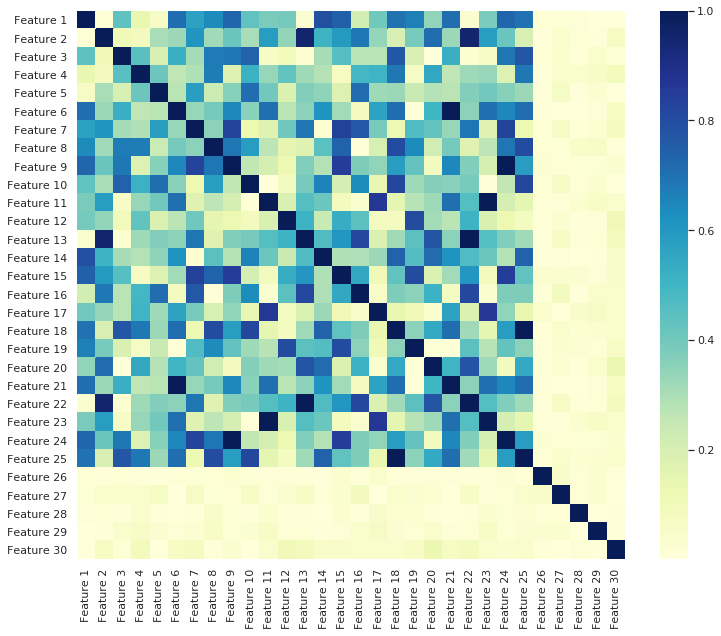

In [12]:
# Feature Selection: Removing highly correlated features  
    
# Filter Method: Spearman's Cross Correlation > 0.95
# Make correlation matrix
corr_matrix = X_train.corr(method = "spearman").abs()

# Draw the heatmap
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()
plt.savefig("correlation_matrix.png", dpi = 1080)

# Select upper triangle of matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features
X_train = X_train.drop(to_drop, axis = 1)
X_test = X_test.drop(to_drop, axis = 1)

### II. Wrapper Method: Recursive Feature Elimination with Cross Validation

After removing highly correlated features, further reduce the number of features can be performed by applying the Scikit-learn recursive feature elimination with cross validation (RFECV). RFECV object only allows you to use estimators/classifiers that have feature_importances_ or coef_attributes. and often RFECV overestimates the number of features really needed.
 

#### II.a. Tuning the Base Estimator

- Select the base estimator to use with RFECV. For the sake of illustration, Random Forest Classifier is chosen as the base. Any of the following as the base estimator can be chosen.



In [13]:
# Create dict for classifiers with feature_importances_ attribute
FEATURE_IMPORTANCE = {"Gradient Boosting", "Extra Trees Ensemble", "Random Forest"}

- Once the base estimator is determined, we will tune its hyper-parameters.The reasons to do this are to reduce the risk over-fitting and to maximize the estimator’s performance. 

- Choosing a Scikit-learn Pipeline object that will be used with the Scikit-learn GridSearchCV object.

*GridSearchCV will perform an exhaustive search over the hyper-parameter grid and will report the hyper-parameters that will maximize the cross-validated classifier performance*.

##### Pipeline Steps:

1. **Feature Scaling:** To ensure that all the features in your data set have the same scale. So that, features with larger values won’t dominate over features with smaller values. 
    - The samples in the training set will be used to scale the data (training and test) via Z-score normalization.
    - All features are centered around zero and have a standard deviation of 1.

2. **Classifier**: Defining the Classifier object to use in the Pipeline.

In [14]:
# 7. Tuning a classifier to use with RFECV  

# Define classifier to use as the base of the recursive feature elimination algorithm
selected_classifier = "Random Forest"
classifier = classifiers[selected_classifier]

    
# Scale features via Z-score normalization
scaler = StandardScaler()

# Define steps in pipeline
steps = [("scaler", scaler), ("classifier", classifier)]

# Initialize Pipeline object
pipeline = Pipeline(steps = steps)
  
# Define parameter grid
param_grid = parameters[selected_classifier]

# Initialize GridSearch object
gscv = GridSearchCV(pipeline, param_grid, cv = 5,  n_jobs= -1, verbose = 1, scoring = "roc_auc")
                  
# Fit gscv
print(f"Now tuning {selected_classifier}.It may take a while ... ")
gscv.fit(X_train, np.ravel(y_train))  

# Get best parameters and score
best_params = gscv.best_params_
best_score = gscv.best_score_
        
# Update classifier parameters
tuned_params = {item[12:]: best_params[item] for item in best_params}
classifier.set_params(**tuned_params)

Now tuning Random Forest.It may take a while ... 
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:  9.1min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.005, min_samples_split=0.01,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

#### II. b. Recursively Selecting Features with the Tuned Estimator

- Once we tuned our base estimator, Another pipeline similar to the first one is created, but this one will have the tuned classifier in the second step.
- Since Scikit-learn Pipeline object does not have feature_importances_ or coef_attributes, we will have to create our own pipeline object  to use it with RFECV.

In [15]:
# 8. Custom pipeline object to use with RFECV

# Select Features using RFECV
class PipelineRFE(Pipeline):
    # Source: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

In [16]:
# 9. Feature Selection: Recursive Feature Selection with Cross Validation   

# Define pipeline for RFECV
steps = [("scaler", scaler), ("classifier", classifier)]
pipe = PipelineRFE(steps = steps)

# Initialize RFECV object
feature_selector = RFECV(pipe, cv = 5, step = 1, scoring = "roc_auc", verbose = 1)

# Fit RFECV
feature_selector.fit(X_train, np.ravel(y_train))

# Get selected features
feature_names = X_train.columns
selected_features = feature_names[feature_selector.support_].tolist()

Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.


## Visualization 

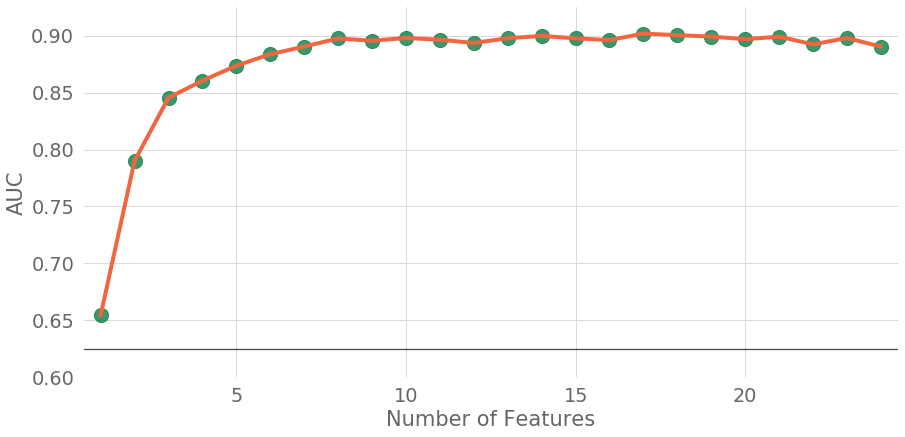

In [17]:
# 10. Performance Curve

# Get Performance Data
performance_curve = {"Number of Features": list(range(1, len(feature_names) + 1)),
                    "AUC": feature_selector.grid_scores_}
performance_curve = pd.DataFrame(performance_curve)

# Performance vs Number of Features
# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})
colors = sns.color_palette("RdYlGn", 20)
line_color = colors[3]
marker_colors = colors[-1]

# Plot
f, ax = plt.subplots(figsize=(13, 6.5))
sns.lineplot(x = "Number of Features", y = "AUC", data = performance_curve,
             color = line_color, lw = 4, ax = ax)
sns.regplot(x = performance_curve["Number of Features"], y = performance_curve["AUC"],
            color = marker_colors, fit_reg = False, scatter_kws = {"s": 200}, ax = ax)

# Axes limits
plt.xlim(0.5, len(feature_names)+0.5)
plt.ylim(0.60, 0.925)

# Generate a bolded horizontal line at y = 0
ax.axhline(y = 0.625, color = 'black', linewidth = 1.3, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Save Figure
plt.savefig("performance_curve.png", dpi = 1080)

Given figure shows the classifier’s performance as a function of a number of features.the performance peak’s around 8 features with an AUC of about 0.89; however, if we were to inspect the length of the selected_features list, we notice that RFECV determined over 17 features are needed to reach the peak performance. We started with 30 features knowing only 5 of them were truly necessary and that after our feature selection algorithm we ended up with over 18 representative features we determine here visually from the given figure how many feature is desired and the [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) RFE object is used.

We notice after 8 feature the performance gain is very minimal so this could be used as threshold; however, some redundancy could be included since we donot know the optimal number of features for the other classifiers.(so let us use number of features = 10)

Scikit-learn RFE documentation:

> Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features … That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.


## Recursive Feature Elimination


In [18]:
#   11. Feature Selection: Recursive Feature Selection

# Define pipeline for RFECV
steps = [("scaler", scaler), ("classifier", classifier)]
pipe = PipelineRFE(steps = steps)

# Initialize RFE object
feature_selector = RFE(pipe, n_features_to_select = 10, step = 1, verbose = 1)

# Fit RFE
feature_selector.fit(X_train, np.ravel(y_train))

# Get selected features labels
feature_names = X_train.columns
selected_features = feature_names[feature_selector.support_].tolist()

Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.


- We did not use RFE to begin with instead of RFECV because in real life scenarios, the number of feature will not be known beforehand.
- By using RFECV we are able to obtain the performanc curve from which number of feature required could be estimated.

` A disadvantage of using RFE is that the results are not cross-validated.`

## Feature Importance

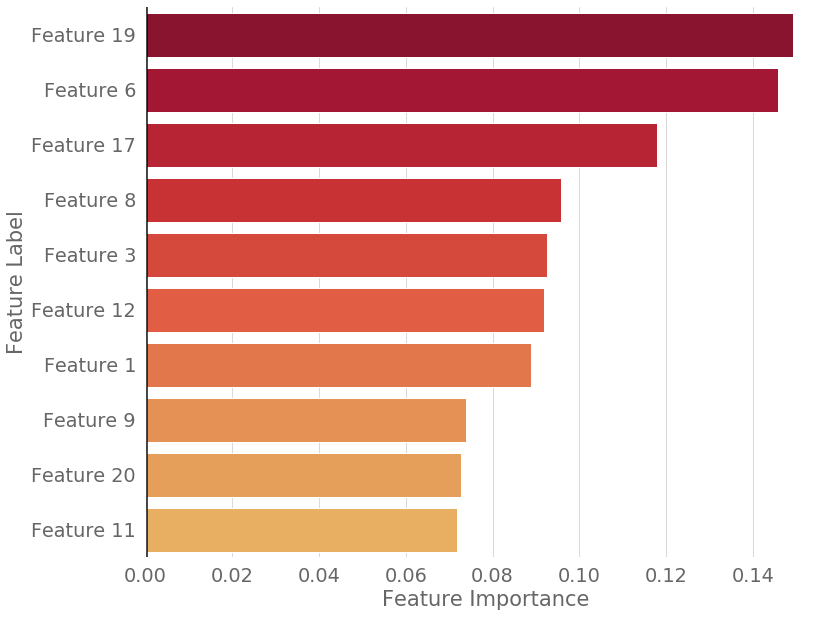

In [19]:
#  12. Visualizing Selected Features Importance     

# Get selected features data set
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Train classifier
classifier.fit(X_train, np.ravel(y_train))

# Get feature importance
feature_importance = pd.DataFrame(selected_features, columns = ["Feature Label"])
feature_importance["Feature Importance"] = classifier.feature_importances_

# Sort by feature importance
feature_importance = feature_importance.sort_values(by="Feature Importance", ascending=False)

# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

# Set figure size and create barplot
f, ax = plt.subplots(figsize=(12, 9))
sns.barplot(x = "Feature Importance", y = "Feature Label",
            palette = reversed(sns.color_palette('YlOrRd', 15)),  data = feature_importance)

# Generate a bolded horizontal line at y = 0
ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Save Figure
plt.savefig("feature_importance.png", dpi = 1080)

Among the most important features are feature 6 and 19 which belong to the class of redundant features. It might seem counter-intuitive that the redundant features seem to be more important than the informative features (features 1–5). Feature engineering can often give a boost. It’s important to note that feature importances assigned by a machine learning classifier that is random in nature are not robust.For example, if one were to rerun RFE, the result obtained might slightly be different since the seed in the Random Forest was not fix. Hence Cross-validating the result is always crucial.


## Iterative Classifier Tuning and Evaluation

After determining subset of representative features, Tuning and training models to investigate the higest performing model among them.

> "This Script took about 55 minutes to run on my workstation so it may take a while "

In [20]:
# 13. Classifier Tuning and Evaluation 

# Initialize dictionary to store results
results = {}

# Tune and evaluate classifiers
for classifier_label, classifier in classifiers.items():
    # Print message to user
    print(f"Now tuning {classifier_label}.")
    
    # Scale features via Z-score normalization
    scaler = StandardScaler()
    
    # Define steps in pipeline
    steps = [("scaler", scaler), ("classifier", classifier)]
    
    # Initialize Pipeline object
    pipeline = Pipeline(steps = steps)
      
    # Define parameter grid
    param_grid = parameters[classifier_label]
    
    # Initialize GridSearch object
    gscv = GridSearchCV(pipeline, param_grid, cv = 5,  n_jobs= -1, verbose = 1, scoring = "roc_auc")
                      
    # Fit gscv
    gscv.fit(X_train, np.ravel(y_train))  
    
    # Get best parameters and score
    best_params = gscv.best_params_
    best_score = gscv.best_score_
    
    # Update classifier parameters and define new pipeline with tuned classifier
    tuned_params = {item[12:]: best_params[item] for item in best_params}
    classifier.set_params(**tuned_params)
            
    # Make predictions
    if classifier_label in DECISION_FUNCTIONS:
        y_pred = gscv.decision_function(X_test)
    else:
        y_pred = gscv.predict_proba(X_test)[:,1]
    
    # Evaluate model
    auc = metrics.roc_auc_score(y_test, y_pred)
    
    # Save results
    result = {"Classifier": gscv,
              "Best Parameters": best_params,
              "Training AUC": best_score,
              "Test AUC": auc}
    
    results.update({classifier_label: result})

Now tuning LDA.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Now tuning QDA.
Fitting 5 folds for each of 101 candidates, totalling 505 fits


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 505 out of 505 | elapsed:    1.2s finished
/home/mnpr_term/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Now tuning AdaBoost.
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   20.3s finished


Now tuning Bagging.
Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:   21.7s finished


Now tuning Extra Trees Ensemble.
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:  6.0min finished


Now tuning Gradient Boosting.
Fitting 5 folds for each of 4320 candidates, totalling 21600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 11226 tasks      

Now tuning Random Forest.
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:  8.7min finished


Now tuning Ridge.
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Now tuning SGD.
Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  55 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Now tuning BNB.
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Now tuning GNB.
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Now tuning KNN.
Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Done  32 out of  55 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend 

Now tuning MLP.
Fitting 5 folds for each of 3888 candidates, totalling 19440 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 11226 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 12776 tasks      | elapsed: 13

Now tuning LSVC.
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Now tuning NuSVC.
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s


Now tuning SVC.
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s


Now tuning DTC.
Fitting 5 folds for each of 3072 candidates, totalling 15360 fits


[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 5640 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 11240 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 15337 out of 15360 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 15360 out of 15360 | elapsed:   15.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s


Now tuning ETC.
Fitting 5 folds for each of 3072 candidates, totalling 15360 fits


[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 5640 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 11240 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 15360 out of 15360 | elapsed:   15.9s finished


The results are stored in the dictionary `result`,can be accessed by the classifier_label (see Classifiers section).
For each classifier, following objects are stored:
- Classifier : Pipeline object with trained classifier, which can be used to make prediction on new samples
- Best parameters : Dictionary containing parameters that obtained greatest performance in the training set.
- Training AUC : The cross-validated AUC obtained in the training set.
- Test AUC : The AUC obtained in the test set.

## Model Selection

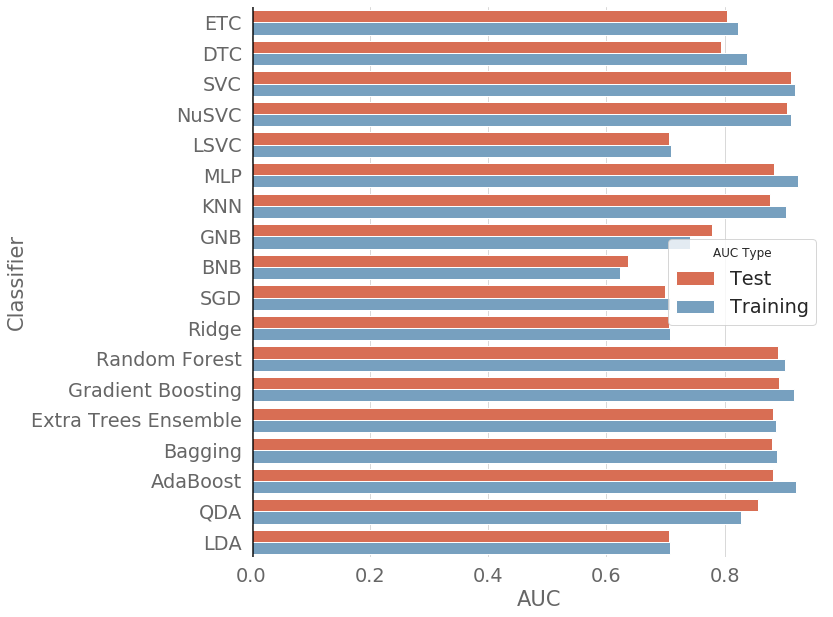

In [21]:
#  14. Visualing Results  

# Initialize auc_score dictionary
auc_scores = {
              "Classifier": [],
              "AUC": [],
              "AUC Type": []
              }

# Get AUC scores into dictionary
for classifier_label in results:
    auc_scores.update({"Classifier": [classifier_label] + auc_scores["Classifier"],
                       "AUC": [results[classifier_label]["Training AUC"]] + auc_scores["AUC"],
                       "AUC Type": ["Training"] + auc_scores["AUC Type"]})
    
    auc_scores.update({"Classifier": [classifier_label] + auc_scores["Classifier"],
                       "AUC": [results[classifier_label]["Test AUC"]] + auc_scores["AUC"],
                       "AUC Type": ["Test"] + auc_scores["AUC Type"]})

# Dictionary to PandasDataFrame
auc_scores = pd.DataFrame(auc_scores)

# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

    
# Colors
training_color = sns.color_palette("RdYlBu", 10)[1]
test_color = sns.color_palette("RdYlBu", 10)[-2]
colors = [training_color, test_color]

# Set figure size and create barplot
f, ax = plt.subplots(figsize=(12, 9))

sns.barplot(x="AUC", y="Classifier", hue="AUC Type", palette = colors,
            data=auc_scores)

# Generate a bolded horizontal line at y = 0
ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Save Figure
plt.savefig("AUC Scores.png", dpi = 1080)

From given figure, we can visualize that SVC, NuSVC, ADaboost,Gradient boosting, ADaboost classifiers obtained the higest performance in the test set. Numerical results in the panda dataframe object `auc_scores` 

*Furthermore, running girdsearch with different parameters on best performing five classifiers, the best three out of five by using `sklearn.ensemble.VotingClassifier`. This would most likely result in a higher performance but would increase the complexity of the modeling.*

**References**

- [1.] [Feature Selection with scikitlearn ](https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/)
- [2.] [Introduction to feature selection methods with an example ](https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/)
- [3.] [An Introduction to Grid Search](https://medium.com/datadriveninvestor/an-introduction-to-grid-search-ff57adcc0998)
- [4.] [Embrace Randomness in Machine Learning](https://machinelearningmastery.com/randomness-in-machine-learning/)
- [5.] [Code Reference](https://github.com/frank-ceballos/Model_Design-Selection/blob/master/Source%20Code/app.py)

---